## LSTM

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

In [241]:
all_stocks = pd.read_csv('all_stocks_5yr.csv')
all_stocks['Name'].unique()[:25]

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB'], dtype=object)

In [242]:
all_stocks['Name'].unique()
stock_name = input()
stock_name = stock_name.upper()
df = all_stocks.loc[all_stocks['Name'] == stock_name]

goog


In [243]:
df.index = pd.DatetimeIndex(df['date'])
df = df[['close', 'volume']]
df

,close,volume
date,,
2014-03-27,558.46,13052
2014-03-28,559.99,41003
2014-03-31,556.97,10772
2014-04-01,567.16,7932
2014-04-02,567.00,146697
...,...,...
2018-02-01,1167.70,2412114
2018-02-02,1111.90,4857943
2018-02-05,1055.80,3798301


In [244]:
train = df.iloc[:-21]
test = df.iloc[-21:]
len(train), len(test)

(954, 21)

In [245]:
# Preprocess Data

def preprocess(training_data, testing_data):
  from sklearn.preprocessing import MinMaxScaler 
  scaler = MinMaxScaler() #Scale training data for LSTM between 0 and 1 for better prediction
  training_data = scaler.fit_transform(train)

  X_train = []
  y_train = []
  for i in range(21, training_data.shape[0]):
    X_train.append(training_data[i-21:i]) #X_train is a list of lists each having 30 day data 
    y_train.append(training_data[i, 0]) #y_train is a set of data having values from each 30 day set for the next day after the previous 30 days
  X_train, y_train = np.array(X_train), np.array(y_train) #Convert in np.array foo reshaping 

  last_21_day_data = train.tail(21)
  df_test = last_21_day_data.append(test, ignore_index=True)

  norm_test_set = scaler.transform(df_test) #Scale test data

  X_test = []
  y_test = []
  # Arrange test data similarly as input data 
  for i in range(21, norm_test_set.shape[0]): 
    X_test.append(norm_test_set[i-21:i])
    y_test.append(norm_test_set[i, 0])

  X_test, y_test = np.array(X_test), np.array(y_test)

  return (X_train, y_train, X_test, y_test, scaler)

X_train, y_train, X_test, y_test, scaler = preprocess(train, test)

In [246]:
def modelInitialize():
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Dropout

  regressor = Sequential() #Sequential model for the LSTM

  regressor.add(LSTM(units = 60, activation = 'relu', return_sequences=True, input_shape = (X_train.shape[1], 2)))  
  #regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
  #regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
  #regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 120, activation = 'relu'))
  #regressor.add(Dropout(0.2))

  regressor.add(Dense(units = 1))

  return regressor

In [247]:
regressor = modelInitialize()
regressor.summary() #Model summary giving shapes of layers and parameters

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_212 (LSTM)              (None, 21, 60)            15120     
_________________________________________________________________
lstm_213 (LSTM)              (None, 21, 60)            29040     
_________________________________________________________________
lstm_214 (LSTM)              (None, 21, 80)            45120     
_________________________________________________________________
lstm_215 (LSTM)              (None, 120)               96480     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 121       
Total params: 185,881
Trainable params: 185,881
Non-trainable params: 0
_________________________________________________________________


In [248]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') #compile model

In [249]:
regressor.fit(X_train, y_train, epochs = 50) #Train the model on training data

Epoch 1/50
30/30 [==============================] - 6s 91ms/step - loss: 0.1238
Epoch 2/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0065
Epoch 3/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0024
Epoch 4/50
30/30 [==============================] - 3s 97ms/step - loss: 0.0022
Epoch 5/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0019
Epoch 6/50
30/30 [==============================] - 3s 92ms/step - loss: 0.0020
Epoch 7/50
30/30 [==============================] - 3s 92ms/step - loss: 0.0019
Epoch 8/50
30/30 [==============================] - 3s 93ms/step - loss: 0.0017
Epoch 9/50
30/30 [==============================] - 3s 92ms/step - loss: 0.0018
Epoch 10/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0015
Epoch 11/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0019
Epoch 12/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0017
Epoch 13/50
30/30 [==================

In [250]:
def predict(X_test, y_test, scaler, regressor):
  y_pred = regressor.predict(X_test) #predict values for X_test 
  scale = scaler.scale_
  scale111 = 1/scale[0]
  scale111
  y_test = y_test*scale111
  y_pred = y_pred*scale111

  return y_test, y_pred

y_test, y_pred = predict(X_test, y_test, scaler, regressor)

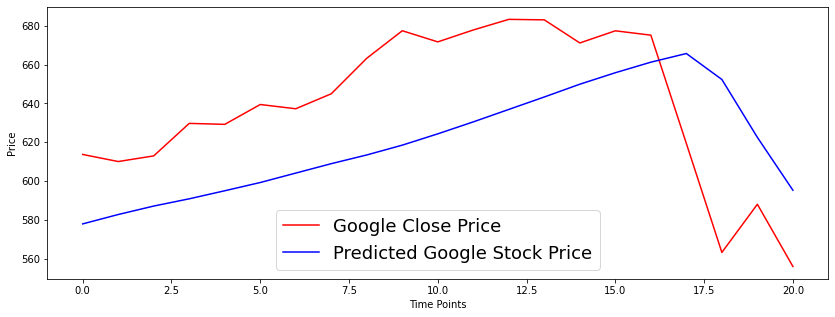

In [251]:
#Plot the predicted values and close price values
plt.figure(figsize = (14, 5))
plt.plot(y_test, color='r', label='Google Close Price')
plt.plot(y_pred, color='b', label='Predicted Google Stock Price')

plt.xlabel('Time Points')
plt.ylabel('Price')
plt.legend(fontsize=18)

In [252]:
X_train[0]

array([[1.07277137e-01, 4.58904271e-04],
       [1.09767412e-01, 2.96414515e-03],
       [1.04851967e-01, 2.54548463e-04],
       [1.21437523e-01, 0.00000000e+00],
       [1.21177102e-01, 1.24374709e-02],
       [1.25636810e-01, 4.55283050e-01],
       [8.23418350e-02, 5.70916888e-01],
       [7.42199580e-02, 3.92724987e-01],
       [1.01482772e-01, 2.81838388e-01],
       [1.16522079e-01, 2.97284819e-01],
       [7.87773238e-02, 3.60294617e-01],
       [6.19313465e-02, 3.50294447e-01],
       [6.50563974e-02, 2.29460023e-01],
       [7.14367096e-02, 3.44135271e-01],
       [1.04152086e-01, 4.36672241e-01],
       [7.08833152e-02, 6.08358368e-01],
       [5.87086378e-02, 2.28850003e-01],
       [6.87836716e-02, 2.10763349e-01],
       [5.59742183e-02, 1.83125570e-01],
       [5.30770358e-02, 1.67969091e-01],
       [3.84609124e-02, 1.87266285e-01]])

In [258]:
preds = []
start_price = []
for k in range(25):
    df_c = all_stocks[k*1259:(k+1)*1259]
    
    size = int(len(df_c) * (1259-21)/1259)
    train = df_c[['close', 'volume']].iloc[:size]
    test = df_c[['close', 'volume']].iloc[size:]
    X_train, y_train, X_test, y_test, scaler = preprocess(train, test)
    regressor = modelInitialize()
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') #compile model
    regressor.fit(X_train, y_train, epochs = 50) #Train the model on training data
    y_test, predictions = predict(X_test, y_test, scaler, regressor)
    preds.append(predictions[-1])
    start_price.append(predictions[0])

Epoch 1/50
39/39 [==============================] - 7s 92ms/step - loss: 0.1925
Epoch 2/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0077
Epoch 3/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0043
Epoch 4/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0038
Epoch 5/50
39/39 [==============================] - 4s 97ms/step - loss: 0.0038
Epoch 6/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0037
Epoch 7/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0037
Epoch 8/50
39/39 [==============================] - 4s 93ms/step - loss: 0.0039
Epoch 9/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0038
Epoch 10/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0041
Epoch 11/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0030
Epoch 12/50
39/39 [==============================] - 4s 91ms/step - loss: 0.0026
Epoch 13/50
39/39 [==================

In [259]:
preds_list = [preds[i][0] for i in range(len(preds))]
start_price = [start_price[i][0] for i in range(len(start_price))]

preds_list, start_price

([40.140266,
  105.65548,
  37.66195,
  75.13035,
  43.238846,
  25.50768,
  86.277885,
  164.23953,
  41.652267,
  10.059665,
  56.442726,
  78.65607,
  89.1984,
  22.064735,
  24.235039,
  2.1525023,
  139.0408,
  41.749596,
  104.97053,
  22.290682,
  13.360229,
  57.247185,
  30.510984,
  31.867573,
  66.10388],
 [41.839825,
  116.15669,
  33.90952,
  67.57211,
  47.939217,
  24.38828,
  87.626144,
  148.04132,
  45.994392,
  9.296078,
  61.586536,
  78.1213,
  112.973274,
  25.247786,
  29.466475,
  2.4226916,
  132.3915,
  40.43494,
  89.5247,
  22.866928,
  16.587347,
  66.09623,
  27.985971,
  34.308575,
  92.26885])

In [261]:
all_stocks_names = all_stocks['Name'].unique()[:25].tolist()

df = pd.DataFrame({'Last Price':start_price, 'Predicted Price': preds_list}, index=all_stocks_names)

In [273]:
df

,Last Price,Predicted Price
AAL,41.839825,40.140266
AAPL,116.156693,105.655479
AAP,33.909519,37.661949
ABBV,67.572113,75.130348
ABC,47.939217,43.238846
ABT,24.388281,25.507681
ACN,87.626144,86.277885
ADBE,148.041321,164.239532
ADI,45.994392,41.652267
ADM,9.296078,10.059665


In [274]:
from google.colab import files

df.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>